In [1]:
%matplotlib notebook
from copy import deepcopy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model

from disp import set_font_size


DATA_DIR = 'data/CL_360_LOWFLOW_ACV'

# Single trial examples

## Print trial list

In [2]:
TRIAL_PATHS = {}

for fly in os.listdir(DATA_DIR):
    for trial in os.listdir(os.path.join(DATA_DIR, fly)):
        
        trial_path = os.path.join(fly, trial)
        TRIAL_PATHS[trial] = trial_path
        
        print('\'{}\''.format(trial))
        
    print('')
    
del trial_path

'20180119.Fly9.2'

'20180201.Fly3.2'
'20180201.Fly3.4'

'20180131.Fly1.3'
'20180131.Fly1.2'

'20180120.Fly1.2'
'20180120.Fly1.1'
'20180120.Fly1.3'

'20170826.Fly4.1'

'20170828.Fly2.2'
'20170828.Fly2.6'

'20170822.Fly1.1'

'20170828.Fly4.3'

'20180119.Fly10.1'

'20180125.Fly6.1'

'20170826.Fly7.2'

'20180131.Fly9.3'

'20180124.Fly4.2'
'20180124.Fly4.3'

'20180131.Fly8.1'
'20180131.Fly8.2'
'20180131.Fly8.4'
'20180131.Fly8.3'

'20180119.Fly7.2'

'20180131.Fly7.2'
'20180131.Fly7.3'

'20170821.Fly1.1'

'20180131.Fly4.3'
'20180131.Fly4.2'

'20180125.Fly3.3'
'20180125.Fly3.4'



## List time series columns

In [3]:
COLUMNS = []

data = pd.read_csv(os.path.join(DATA_DIR, list(TRIAL_PATHS.values())[0], 'clean.csv'))

for column in data.columns:
    COLUMNS.append(column)
    print(column)
    
del column
del data

Time
xpos
ypos
ForVel
AngVel
LatVel
Motion
Heading
ForVel_Conv
AngVel_Conv
LatVel_Conv
Motion_Conv
G2_Red_R
G3_Red_R
G4_Red_R
G5_Red_R
G2_Red_L
G3_Red_L
G4_Red_L
G5_Red_L
G2_Green_R
G3_Green_R
G4_Green
G5_Green_R
G2_Green_L
G3_Green_L
G4_Green_L
G5_Green_L
G2_R
G3_R
G4_R
G5_R
G2_L
G3_L
G4_L
G5_L
G2_avg
G3_avg
G4_avg
G5_avg


## Plot example multivariate time series

### Define plot fn

In [4]:
def plot_vars(trial, t_lim, *vs, **kwargs):
    """Plot variables for single trial."""
    
    cols = [v[0] for v in vs]  # columns
    cs = [v[1] for v in vs]  # colors
    
    for col in cols:
        assert col in COLUMNS

    # load data
    data = pd.read_csv(os.path.join(DATA_DIR, TRIAL_PATHS[trial], 'clean.csv'))
    t = data['Time']
    
    # load odor
    odor = pd.read_csv(os.path.join(DATA_DIR, TRIAL_PATHS[trial], 'odor_times.csv'))
    
    fig_size = (9, 2*len(vs))
    fig, axs = plt.subplots(len(vs), 1, figsize=fig_size, tight_layout=True, sharex=True, squeeze=False)
    
    title = '{} - {}'.format(kwargs['title'], trial) if 'title' in kwargs else trial
    axs[0, 0].set_title(title)
    axs[-1, 0].set_xlabel('Time (s)')
    
    for col, c, ax in zip(cols, cs, axs[:, 0]):
        
        # time-series var
        ax.plot(t, data[col], color=c, lw=1)
        
        # odor
        for p_ctr in range(len(odor)):
            
            pulse = odor.iloc[p_ctr]
            
            p_start = pulse['Odor_On']
            p_end = pulse['Odor_Off']
            
            p_c = 'r' if pulse['Include'] else 'k'
            
            ax.axvspan(p_start, p_end, color=p_c, alpha=0.2)
            
        ax.set_xlim(t_lim)
        
        ax.set_ylabel(col)
        
        ax.grid()
        
        set_font_size(ax, 16)
        
    return fig, axs

<IPython.core.display.Javascript object>


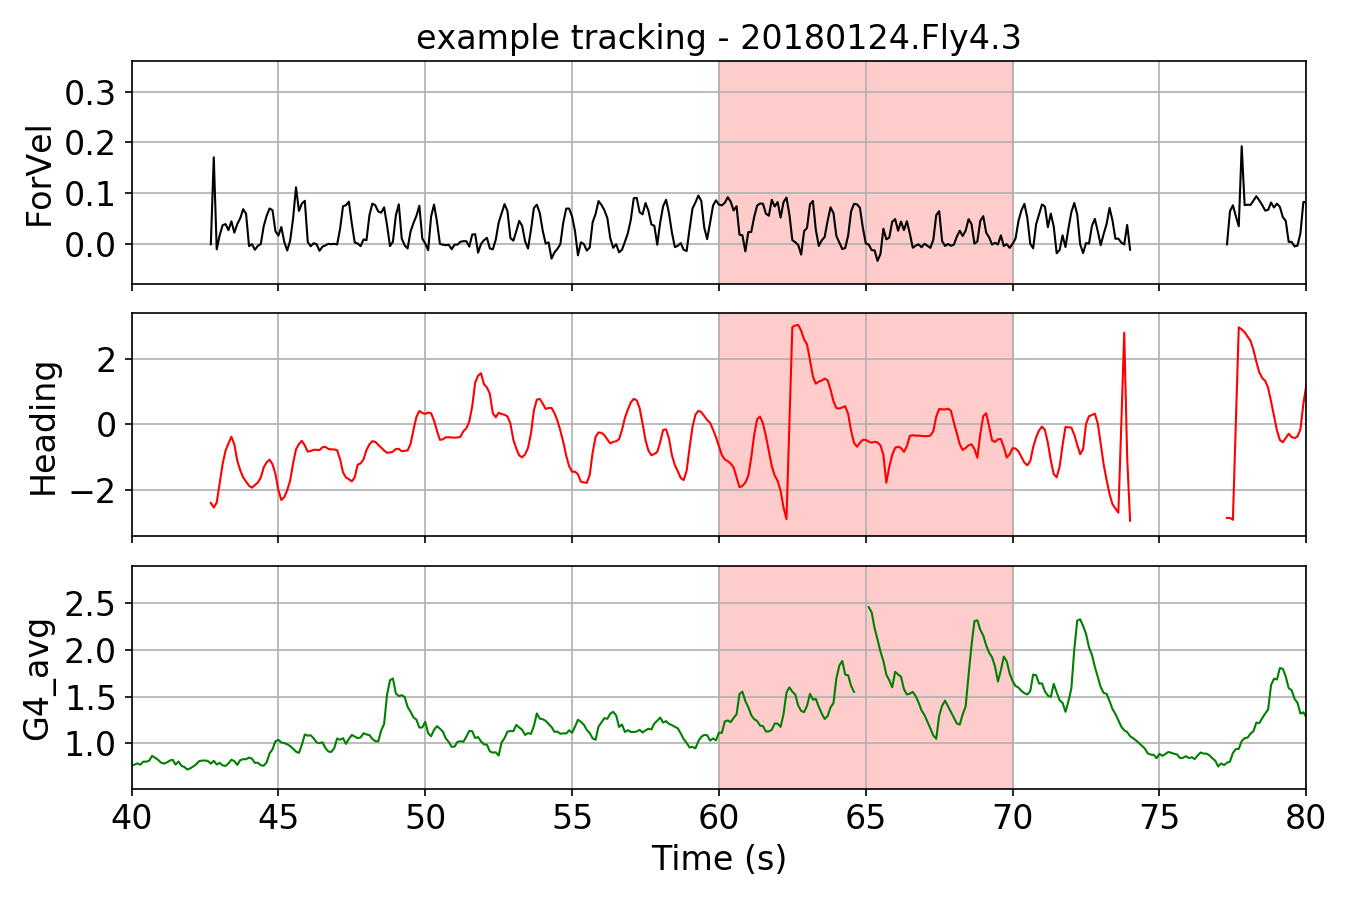

In [5]:
plot_vars(
    '20180124.Fly4.3',
    (40, 80),
    ('ForVel', 'k'),
    ('Heading', 'r'),
    ('G4_avg', 'g'),
    title='example tracking',
);

<IPython.core.display.Javascript object>


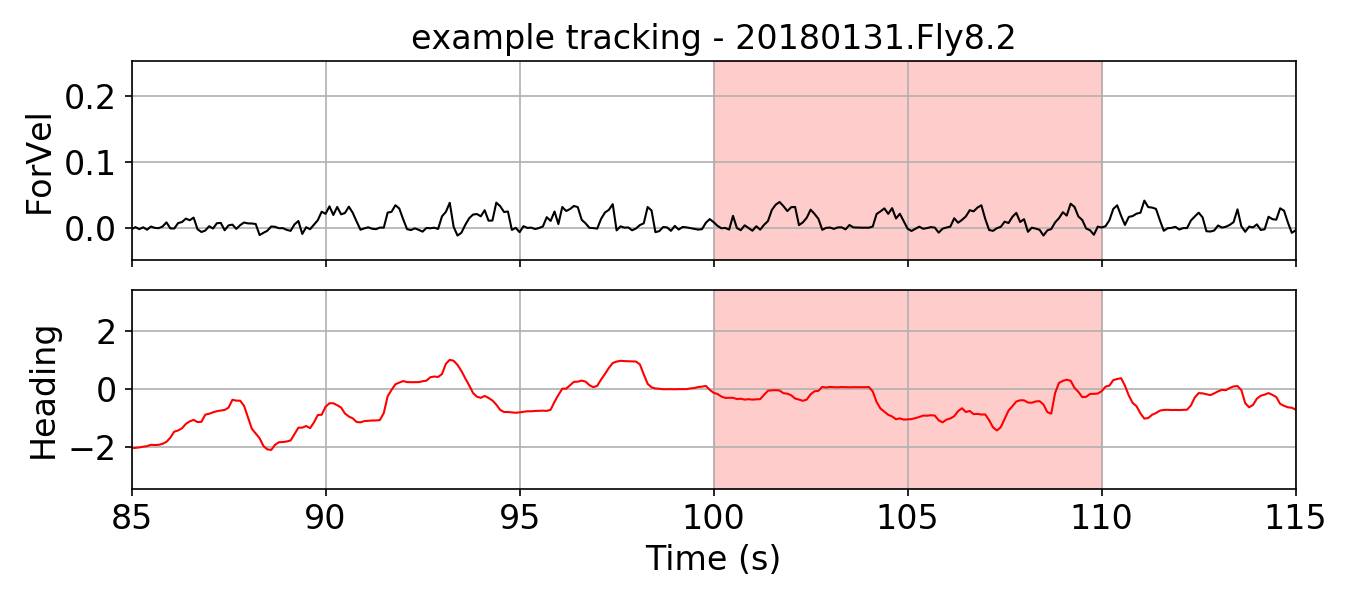

In [6]:
plot_vars(
    '20180131.Fly8.2',
    (85, 115),
    ('ForVel', 'k'),
    ('Heading', 'r'),
    title='example tracking',
);

# Odor-triggered metrics

## Define metrics

In [7]:
def calc_metrics(trial, data, pulse):
    """Calculate metrics for each odor pulse."""
    
    p_on = pulse['Odor_On']
    p_off = pulse['Odor_Off']
    
    rslt = {}
    
    rslt['Trial'] = trial
    rslt['On'] = p_on
    rslt['Off'] = p_off
    rslt['Include'] = 'Include' if pulse['Include'] else 'Exclude'
    
    # Preliminary
    t = np.array(data['Time'])
    
    ###### METRIC ######
    # G4_avg t-avg'd from 10 to 0 s pre odor onset
    t_mask_0 = (p_on-10 <= t) & (t < p_on)
    rslt['g4_neg10_0'] = np.nanmean(np.array(data['G4_avg'][t_mask_0]))
    
    del t_mask_0
    
    ###### METRIC ######
    # dF/F G4_avg t-avg'd from 1 to 4 s post odor onset
    t_mask = (p_on+1 <= t) & (t < p_on+4)
    rslt['d_g4_1_4'] = (np.nanmean(np.array(data['G4_avg'])[t_mask]) - rslt['g4_neg10_0']) / rslt['g4_neg10_0']
    
    del t_mask
    
    ###### METRIC ######
    # abs heading t-avg'd from 10 to 0 s pre odor onset
    t_mask_0 = (p_on-10 <= t) & (t < p_on)
    rslt['h_neg10_0'] = np.nanmean(np.abs(data['Heading'][t_mask_0]))
    
    del t_mask_0
    
    ###### METRIC ######
    # change in abs heading from h_neg10_0, t-avgd from 1 to 4 s post odor onset
    t_mask = (p_on+1 <= t) & (t < p_on+4)
    rslt['d_h_1_4'] = np.nanmean(np.abs(data['Heading'][t_mask])) - rslt['h_neg10_0']
    
    del t_mask
    
    ###### METRIC ######
    # change in abs heading from h_neg10_0, t-avgd from 7 to 10 s post odor onset 
    t_mask = (p_on+7 <= t) & (t < p_on+10)
    rslt['d_h_7_10'] = np.nanmean(np.abs(data['Heading'][t_mask])) - rslt['h_neg10_0']
    
    del t_mask
    
    ###### METRIC ######
    # forward velocity t-avgd from 10 to 0 s pre odor onset
    t_mask_0 = (p_on-10 <= t) & (t < p_on)
    rslt['v_neg10_0'] = np.nanmean(data['ForVel'][t_mask_0])
    
    del t_mask_0
    
    ##### METRIC #####
    # change in forward velocity from v_neg10_0, t-avgd 1 to 4 s after odor onset
    t_mask = (p_on+1 <= t) & (t < p_on+4)
    rslt['d_v_1_4'] = np.nanmean(data['ForVel'][t_mask]) - rslt['v_neg10_0']
    
    del t_mask
    
    ##### METRIC #####
    # change in forward velocity from v_neg10_0, t-avgd 7 to 10 s after odor onset
    t_mask = (p_on+7 <= t) & (t < p_on+10)
    rslt['d_v_7_10'] = np.nanmean(data['ForVel'][t_mask]) - rslt['v_neg10_0']
    
    del t_mask
    
    return rslt

# Nested model analysis

## Compute all metrics

In [8]:
metrics_dicts = []

for trial, trial_path in TRIAL_PATHS.items():
    
    data = pd.read_csv(os.path.join(DATA_DIR, TRIAL_PATHS[trial], 'clean.csv'))
    odor = pd.read_csv(os.path.join(DATA_DIR, TRIAL_PATHS[trial], 'odor_times.csv'))
    
    # loop over odor pulses
    for p_ctr in range(len(odor)):
        pulse = odor.iloc[p_ctr]
        
        metrics_dicts.append(calc_metrics(trial, data, pulse))

metrics = pd.DataFrame.from_records(metrics_dicts)
metrics.index.name = 'Pulse'

# re-order columns
cols = list(metrics.columns)
cols = [cols.pop(cols.index(col)) for col in ['Trial', 'On', 'Off', 'Include']] + cols
metrics = metrics[cols]

# add control vars to test stats analysis
x_c_1, x_c_2, x_c_3, x_c_4 = np.random.normal(0, 1, (4, len(metrics)))
y_c = x_c_1 + x_c_2 + x_c_3 + np.random.normal(0, 1, len(metrics))

metrics['x_c_1'] = x_c_1
metrics['x_c_2'] = x_c_2
metrics['x_c_3'] = x_c_3
metrics['x_c_4'] = x_c_4
metrics['y_c'] = y_c

metrics

/home/melete/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
/home/melete/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: Mean of empty slice
/home/melete/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: Mean of empty slice
/home/melete/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice


,Trial,On,Off,Include,d_g4_1_4,d_h_1_4,d_h_7_10,d_v_1_4,d_v_7_10,g4_neg10_0,h_neg10_0,v_neg10_0,x_c_1,x_c_2,x_c_3,x_c_4,y_c
Pulse,,,,,,,,,,,,,,,,,
0,20180119.Fly9.2,60,70,Include,0.431444,-0.544933,0.692699,0.004610,0.008243,1.937077,0.998984,0.030889,-0.543512,-1.012030,0.967328,-2.040240,1.431559
1,20180119.Fly9.2,100,110,Include,0.062546,0.720234,-0.182152,0.005726,0.016077,2.185947,1.458485,0.029468,-1.322218,0.189232,-1.534972,-0.881502,-3.852652
2,20180119.Fly9.2,140,150,Exclude,0.053733,1.244173,0.115646,0.000379,-0.010222,2.319133,1.112471,0.037627,0.191223,0.408327,-1.314474,0.922401,-0.105041
3,20180119.Fly9.2,180,190,Exclude,0.373215,-0.803434,0.020690,0.002703,0.011228,1.970728,1.626867,0.032022,-0.013255,0.126563,0.112924,-0.242755,0.921787
4,20180119.Fly9.2,220,230,Include,0.120991,0.306145,1.332358,0.012571,0.011855,2.114286,1.039222,0.027990,-0.887612,0.536312,0.263133,1.162133,-0.728331
5,20180201.Fly3.2,60,70,Exclude,0.789736,0.136584,-1.940321,-0.006203,-0.028832,0.667909,2.582838,0.076922,-0.049593,-0.890576,-1.577461,0.062880,-2.667798
6,20180201.Fly3.2,100,110,Include,0.541078,-0.910679,-0.610550,-0.017611,-0.009887,0.724681,1.851959,0.058200,1.980576,-0.045001,-2.210377,-1.300379,-0.864413
7,20180201.Fly3.2,140,150,Exclude,0.409950,0.516415,1.278269,-0.018928,-0.060752,0.981507,0.936810,0.077085,0.344303,0.338351,0.090963,-0.468638,2.689444
8,20180201.Fly3.2,180,190,Include,0.020633,0.209809,-0.432314,0.034546,0.000052,0.875138,1.438169,0.043127,0.856069,-0.733574,1.324474,1.000177,3.124391


## Specify and fit models

<IPython.core.display.Javascript object>


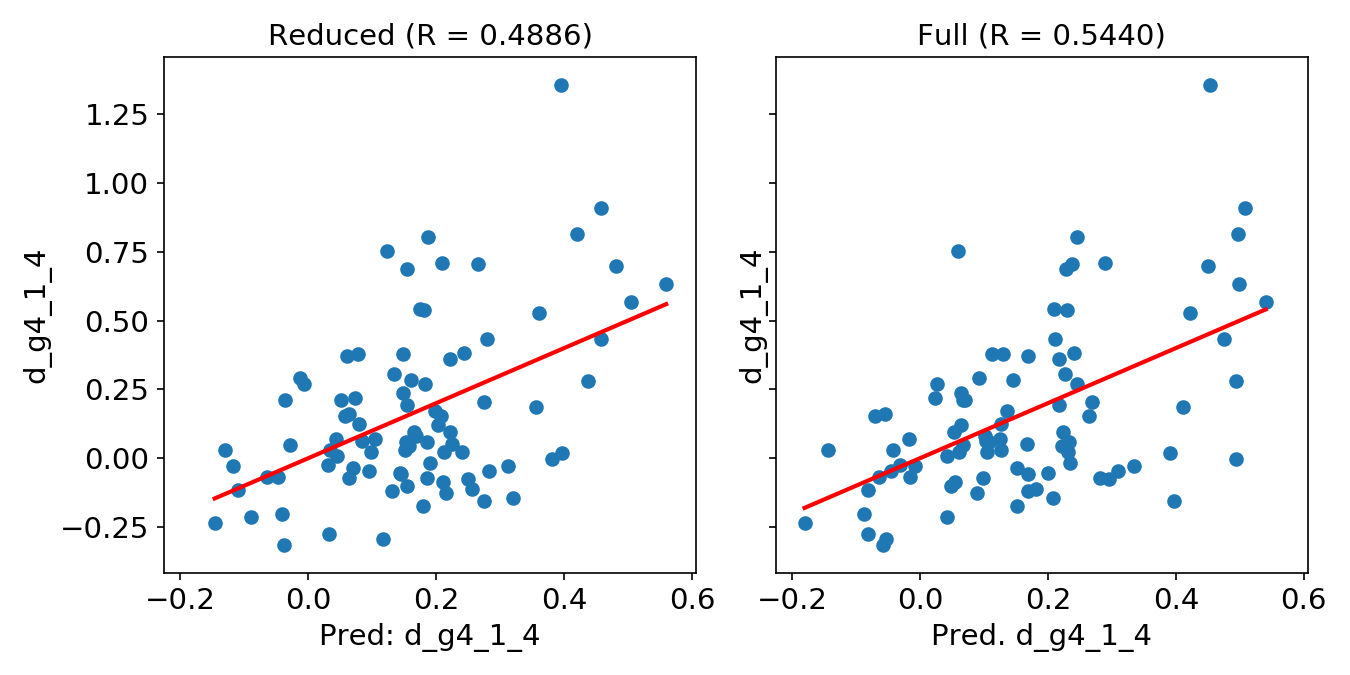

<IPython.core.display.Javascript object>


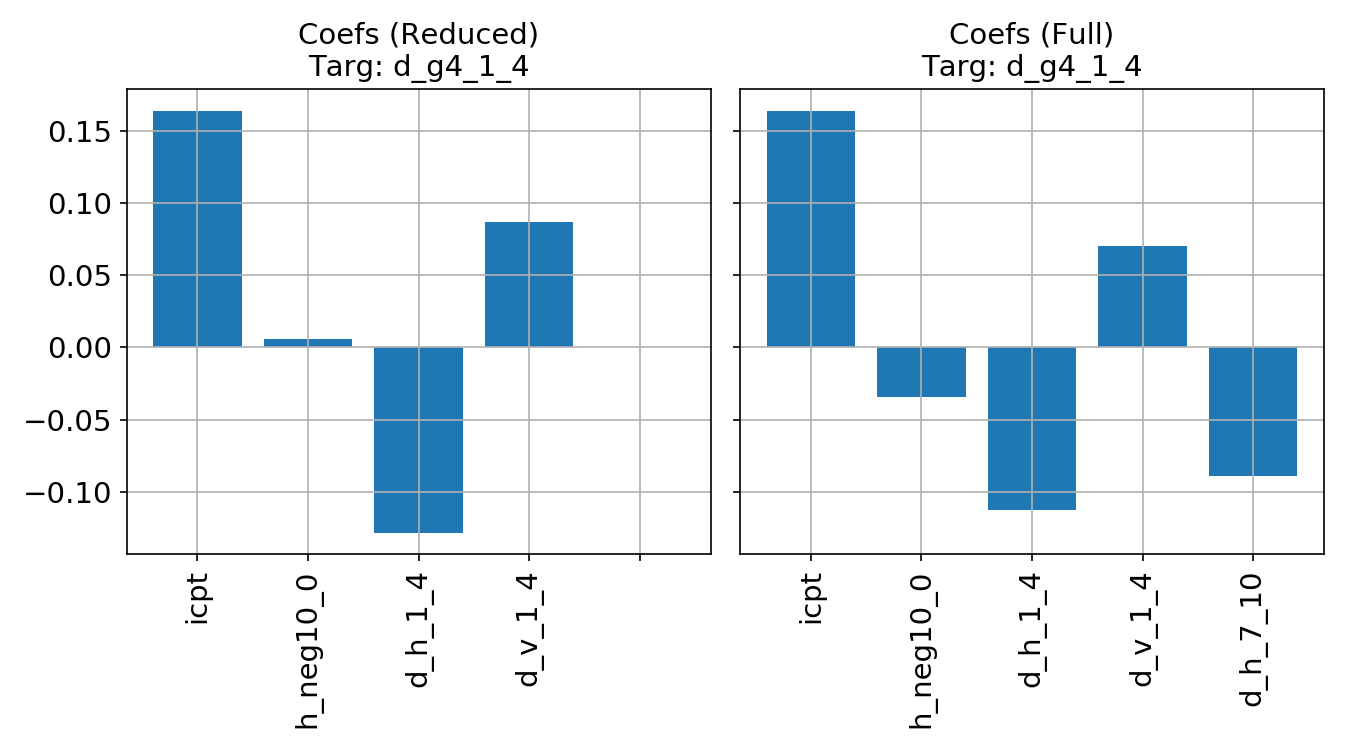

In [11]:
COLS_X_RED = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4']
COLS_X_FULL = ['h_neg10_0', 'd_h_1_4', 'd_v_1_4', 'd_h_7_10']

#COLS_X_RED = ['h_neg10_0', 'd_v_1_4']
#COLS_X_FULL = ['h_neg10_0', 'd_v_1_4', 'd_h_1_4']

COL_Y = 'd_g4_1_4'

# UNCOMMENT TO RUN CONTROL ANALYSIS
#COLS_X_FULL = ['h_neg10_0', 'd_h_1_4', 'x_c_1']
#COLS_X_RED = ['x_c_1', 'x_c_2']
#COLS_X_FULL = ['x_c_1', 'x_c_2', 'x_c_3']
#COLS_X_FULL = ['x_c_1', 'x_c_2', 'x_c_4']
#COL_Y = 'y_c'

COLS_ALL = list(set(COLS_X_RED + COLS_X_FULL + [COL_Y]))

for col in COLS_ALL:
    assert col in metrics
assert COL_Y not in COLS_X_RED
assert COL_Y not in COLS_X_FULL

# helper function
def fit_line(x, y):
    slp, icpt = stats.linregress(x, y)[:2]
    x_line = np.array([x.min(), x.max()])
    y_line = slp*x_line + icpt
    
    return x_line, y_line

# filter data
metrics_filt = metrics[COLS_ALL][metrics['Include'] == 'Include'].dropna()
#metrics_filt = metrics[COLS_ALL].dropna()

# fit nested models and plot predictions
fig, axs = plt.subplots(1, 2, figsize=(9, 4.5), sharex=True, sharey=True, tight_layout=True)

## targ
y = metrics_filt[COL_Y]

## reduced

### data
x_red = metrics_filt[COLS_X_RED]
x_red -= x_red.mean(0)
x_red /= x_red.std(0)

### fit
m_red = linear_model.LinearRegression().fit(x_red, y)

### prediction and R2
y_hat_red = m_red.predict(x_red)
r2_red = m_red.score(x_red, y)

### plot
axs[0].scatter(y_hat_red, y)
axs[0].plot(*fit_line(y_hat_red, y), c='r', lw=2)
axs[0].set_title('Reduced (R = {0:.4f})'.format(r2_red**.5))
axs[0].set_xlabel('Pred: {}'.format(COL_Y))
axs[0].set_ylabel(COL_Y)

## full

### data
x_full = metrics_filt[COLS_X_FULL]
x_full -= x_full.mean(0)
x_full /= x_full.std(0)

### fit
m_full = linear_model.LinearRegression().fit(x_full, y)

### prediction and R2
y_hat_full = m_full.predict(x_full)
r2_full = m_full.score(x_full, y)

### plot
axs[1].scatter(y_hat_full, y)
axs[1].plot(*fit_line(y_hat_full, y), c='r', lw=2)
axs[1].set_title('Full (R = {0:.4f})'.format(r2_full**.5))
axs[1].set_xlabel('Pred. {}'.format(COL_Y))
axs[1].set_ylabel(COL_Y)

for ax in axs:
    set_font_size(ax, 14)
    
# plot model coefs
fig, axs = plt.subplots(1, 2, figsize=(9, 5), sharey=True, tight_layout=True)

x_bar = np.arange(1 + len(m_full.coef_))

bar_red = [m_red.intercept_] + list(m_red.coef_) + [0]
axs[0].bar(x_bar, bar_red, align='center', width=0.8)
axs[0].set_xticks(x_bar)
axs[0].set_xticklabels(['icpt'] + COLS_X_RED + [''], rotation=90)
axs[0].set_title('Coefs (Reduced)\nTarg: {}'.format(COL_Y))

bar_full = [m_full.intercept_] + list(m_full.coef_)
axs[1].bar(x_bar, bar_full, align='center', width=0.8)
axs[1].set_xticks(x_bar)
axs[1].set_xticklabels(['icpt'] + COLS_X_FULL, rotation=90)
axs[1].set_title('Coefs (Full)\nTarg: {}'.format(COL_Y))

for ax in axs:
    ax.grid()
    set_font_size(ax, 14)

## Compute statistics

### Calculate F statistic

In [12]:
# RSS
rss_red = np.sum((y - m_red.predict(x_red))**2)
rss_full = np.sum((y - m_full.predict(x_full))**2)

# params
p_red = len(COLS_X_RED) + 1
p_full = len(COLS_X_FULL) + 1

# num samps
n = len(y)

# degs freedom
dfn = p_full - p_red
dfd = n - p_full

# calc F
f = ((rss_red - rss_full) / (p_full - p_red)) / (rss_full / (n - p_full))

# calc p-val
p_val = stats.f.sf(f, dfn, dfd)

print('F = {}'.format(f))
print('P = {}'.format(p_val))
print('N = {}'.format(n))

F = 6.8221074171434735
P = 0.010663525286858627
N = 89
